In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

In [6]:
df = pd.read_csv("data/long_and_short_range_loops_D_mel.tsv", sep="\t")

columns = [
    "Dmel_6-8h_Neuroblasts", "Dmel_6-8h_Neurons", "Dmel_6-8h_Glia",
    "Dmel_10-12h_Neuroblasts", "Dmel_10-12h_Neurons", "Dmel_10-12h_Glia",
    "Dmel_14-16h_Neuroblasts", "Dmel_14-16h_Neurons", "Dmel_14-16h_Glia"
]

df = df[columns]

In [7]:
print("Number of NaN values per column:")
print(df.isna().sum())

# Replace NaNs with 0 !!!
df = df.fillna(0)

print("\nNaN values replaced with 0. Verifying cleanup:")
print(df.isna().sum())

Number of NaN values per column:
Dmel_6-8h_Neuroblasts      6
Dmel_6-8h_Neurons          3
Dmel_6-8h_Glia             3
Dmel_10-12h_Neuroblasts    6
Dmel_10-12h_Neurons        3
Dmel_10-12h_Glia           3
Dmel_14-16h_Neuroblasts    6
Dmel_14-16h_Neurons        3
Dmel_14-16h_Glia           3
dtype: int64

NaN values replaced with 0. Verifying cleanup:
Dmel_6-8h_Neuroblasts      0
Dmel_6-8h_Neurons          0
Dmel_6-8h_Glia             0
Dmel_10-12h_Neuroblasts    0
Dmel_10-12h_Neurons        0
Dmel_10-12h_Glia           0
Dmel_14-16h_Neuroblasts    0
Dmel_14-16h_Neurons        0
Dmel_14-16h_Glia           0
dtype: int64


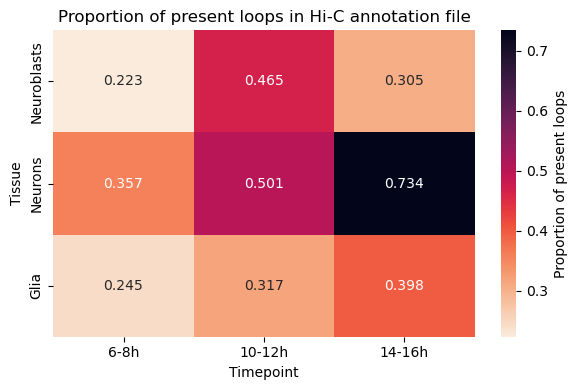

In [8]:
# Heatmapa sum kolumn z surowego pliku 

tissues = ["Neuroblasts", "Neurons", "Glia"]
timepoints = ["6-8h", "10-12h", "14-16h"]

sum_data = pd.DataFrame(index=tissues, columns=timepoints, dtype=float)
for tissue in tissues:
    for tp in timepoints:
        col = f"Dmel_{tp}_{tissue}"
        sum_data.loc[tissue, tp] = df[col].sum()/len(df)

plt.figure(figsize=(6, 4))
sns.heatmap(sum_data, annot=True, cmap="rocket_r", fmt=".3f", cbar_kws={'label': 'Proportion of present loops'})
plt.title("Proportion of present loops in Hi-C annotation file")
plt.xlabel("Timepoint")
plt.ylabel("Tissue")
plt.tight_layout()
#plt.show()
plt.savefig('results/figures/proportion.png')

In [69]:
rix = df[['Dmel_6-8h_Neuroblasts', 'Dmel_6-8h_Neurons', 'Dmel_6-8h_Glia']
].to_numpy()

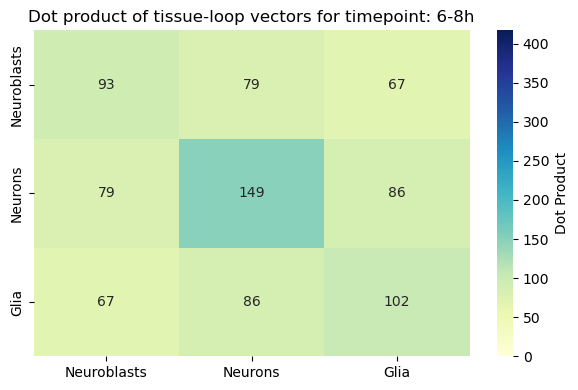

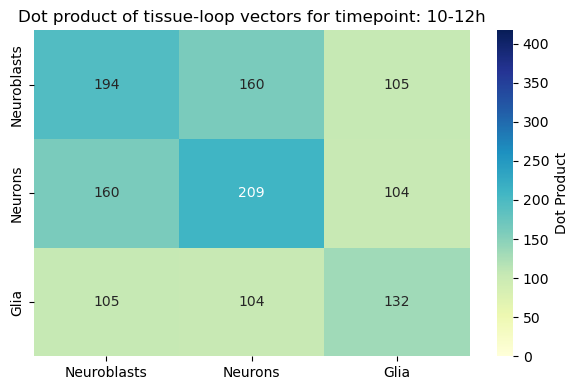

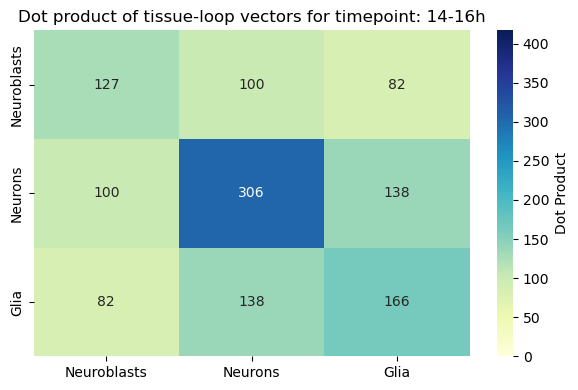

In [22]:
# Iloczyny skalarne pomiędzy tkankami wewnątrz okna czasowego
for tp in timepoints:
    cols = [f"Dmel_{tp}_{tissue}" for tissue in tissues]
    mat = df[cols].to_numpy()
    dot_matrix = np.dot(mat.T, mat)
    dot_df = pd.DataFrame(dot_matrix, index=tissues, columns=tissues)

    plt.figure(figsize=(6, 4))
    sns.heatmap(dot_df, annot=True, fmt=".0f", cmap="YlGnBu",
                cbar_kws={'label': 'Dot Product'},
                vmin=0, vmax=len(df))
    plt.title(f"Dot product of tissue-loop vectors for timepoint: {tp}")
    plt.tight_layout()
    plt.savefig(f'results/figures/dot_product_{tp}.png')

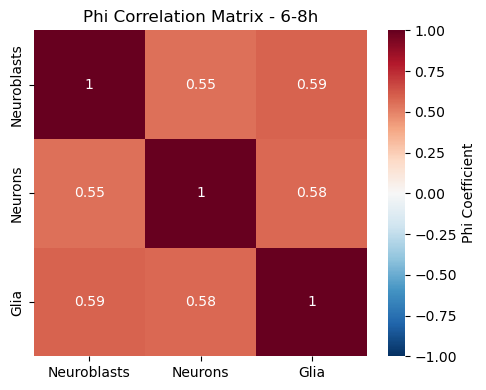

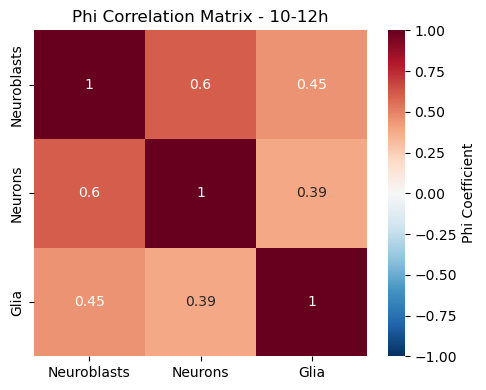

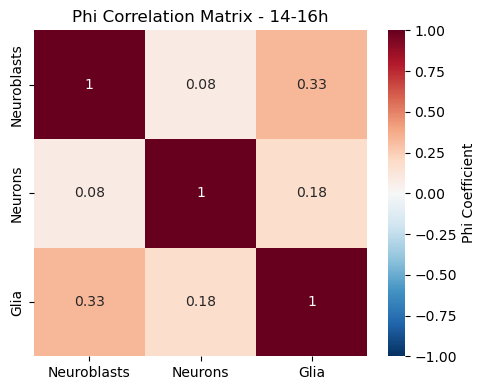

In [103]:
# Correlation matrices

def phi_coefficient(x, y):
    """Compute Pearson's phi coefficient for two binary vectors."""
    contingency = pd.crosstab(x, y)
    if contingency.shape != (2, 2):
        return np.nan
    n = contingency.values.sum()
    a, b, c, d = contingency.values.flatten()
    numerator = (a*d - b*c)
    denominator = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    return numerator / denominator if denominator != 0 else 0

for tp in timepoints:
    cols = [f"Dmel_{tp}_{tissue}" for tissue in tissues]
    phi_mat = pd.DataFrame(index=tissues, columns=tissues, dtype=float)

    for t1, t2 in combinations(tissues, 2):
        phi = phi_coefficient(df[f"Dmel_{tp}_{t1}"], df[f"Dmel_{tp}_{t2}"])
        phi_mat.loc[t1, t2] = phi
        phi_mat.loc[t2, t1] = phi

    np.fill_diagonal(phi_mat.values, 1.0)

    plt.figure(figsize=(5, 4))
    sns.heatmap(phi_mat, annot=True, vmin=-1, vmax=1, cmap="RdBu_r", cbar_kws={'label': "Phi Coefficient"})
    plt.title(f"Phi Correlation Matrix - {tp}")
    plt.tight_layout()
    plt.savefig(f'results/figures/correlations_{tp}.png')